In [2]:
###The Mock stream generator method is too simple regarding the goal of the subject.
#We'll proceed with N-body simulation to seek for observables that could bias the form of the sts,
#and if the position of a star in the stream is related its intrinsic properties
#Here the system is represented by a N-body cluster (globular cluster, let's keep pal5) in a background potential (MW)
# %matplotlib widget
%matplotlib inline
import astropy.units as u
import astropy.constants as ac
import numpy as np
import gala.potential as gp
import matplotlib.pyplot as plt
import gala.dynamics as gd

from gala.dynamics import PhaseSpacePosition
from gala.units import galactic
import astropy.coordinates as coord


with coord.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = coord.Galactocentric()

In [3]:
###Starting by defining particles and background
##bacground MW
mw_pot = gp.MilkyWayPotential()
#mw_pot = gp.LogarithmicPotential(v_c = 220.*u.km/u.s, r_h=1.*u.pc, q3=0.9*u.pc)

##Particles
#Cluster, local background potential
c = coord.ICRS(ra=229 * u.deg, dec=-0.124 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
c_gc = c.transform_to(galcen_frame)

# print(c_gc.cartesian.x)
# print(c_gc.velocity)

w0_pal5 = gd.PhaseSpacePosition(c_gc)
print(w0_pal5)
pal5_mass = 2.5e4 * u.Msun
pot_Pal_5 = gp.PlummerPotential(m=pal5_mass, b=4*u.pc, units=galactic)
def Plummer_sig2v(M, b, r):
    return ac.G * M.to(u.kg) / 6 * (r.to(u.m)**2+b.to(u.m)**2)**(-1/2)

pos=(7.86390455, 0.22748727, 16.41622487) kpc
vel=(-8.93467882, -21.87416788, -3.26703655) kpc mas / (rad yr)


In [4]:
#multiple stars randomly distributed in the cluster
def cluster_stars(cluster_coor, cluster_pot, n_stars, size, v_dispersion):
    w0_stars = [cluster_coor]
    potentials = [cluster_pot]

    cluster_pos = cluster_coor.xyz.to_value(u.pc)  # Cluster position in pc
    cluster_vel = cluster_coor.v_xyz.to_value(u.km/u.s)  # Cluster velocity in km/s

    for _ in range(n_stars):
        # Random position in cluster
        offset = np.random.randn(3) * size  # Random displacement in xyz
        star_pos = cluster_pos + offset  # Star position in pc

        # Compute unit radial vector from cluster center to star
        r_vec = offset / np.linalg.norm(offset)  # Unit radial vector
        #print(r_vec)
        # Generate random velocity
        #vel_random = np.random.randn(3) * v_dispersion  # Random velocity in xyz
        vel_random = np.random.randn(3) * np.sqrt(Plummer_sig2v(pal5_mass, 4*u.pc, np.linalg.norm(offset)*u.pc))

        # # Remove radial component from velocity
        # vel_random -= np.dot(vel_random, r_vec) * r_vec  # Project out radial component

        # Convert to proper units
        star_vel = cluster_vel + vel_random.to_value(u.km/u.s)  # Final velocity in km/s

        # Create phase-space position
        w0_n = PhaseSpacePosition(
            pos=star_pos * u.pc,
            vel=star_vel * u.km/u.s
        )

        w0_stars.append(w0_n)
        potentials.append(None)

    return w0_stars, potentials


In [5]:
#first integrate progenitor back in time until t_disrupt
# print(w0_pal5)
pal5_orbit = mw_pot.integrate_orbit(w0_pal5, dt=-1*u.Myr, t1=0, t2=-4.5*u.Gyr)
pal5_b = pal5_orbit[-1].to_coord_frame(galcen_frame)
pal5_b_pos = gd.PhaseSpacePosition(pal5_b).xyz.to_value(u.kpc)
pal5_b_vel = gd.PhaseSpacePosition(pal5_b).v_xyz.to_value(u.kpc*u.mas/u.yr/u.rad)

w0_pal5_b = gd.PhaseSpacePosition(pos=pal5_b_pos*u.kpc, vel=pal5_b_vel*(u.kpc*u.mas/u.yr/u.rad))
print(w0_pal5)
print(w0_pal5_b)

pos=(7.86390455, 0.22748727, 16.41622487) kpc
vel=(-8.93467882, -21.87416788, -3.26703655) kpc mas / (rad yr)
pos=(5.83889282, -12.34480097, 4.124608) kpc
vel=(-4.4690379, -19.66373814, 35.69174215) kpc mas / (rad yr)


In [6]:
#n stars
w0_stars, potentials = cluster_stars(w0_pal5_b, pot_Pal_5, 5000, 5, 1)
w0 = gd.combine(w0_stars)
# print(w0_stars)

###Integrate orbit
nbody = gd.DirectNBody(w0, potentials, external_potential=mw_pot)

orbits = nbody.integrate_orbit(dt=1*u.Myr, t1=0, t2=4.5*u.Gyr)



In [21]:
#Later, for second integration with damping cluster potential

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


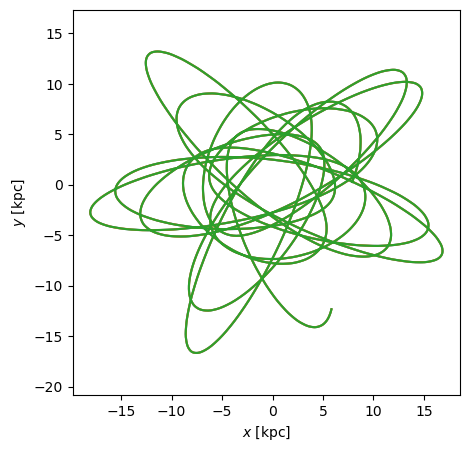

In [7]:
###Display progenitor and 2 random stars orbit for visualisation for visualisation

fig, ax = plt.subplots(1, 1, figsize=(5, 5)) 

_ = orbits[:, 0].plot(['x', 'y'], axes=[ax]) #Cluster

_ = orbits[:, 1].plot(['x', 'y'], axes=[ax])

_ = orbits[:, 2].plot(['x', 'y'], axes=[ax]) 


<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg): (x, y, z) in kpc
    (7.86390455, 0.22748727, 16.41622487)
 (v_x, v_y, v_z) in km / s
    (-42.35458106, -103.69384675, -15.48729026)>
7.888481809223311 kpc 0.27607543080615254 kpc 16.435822058982804 kpc


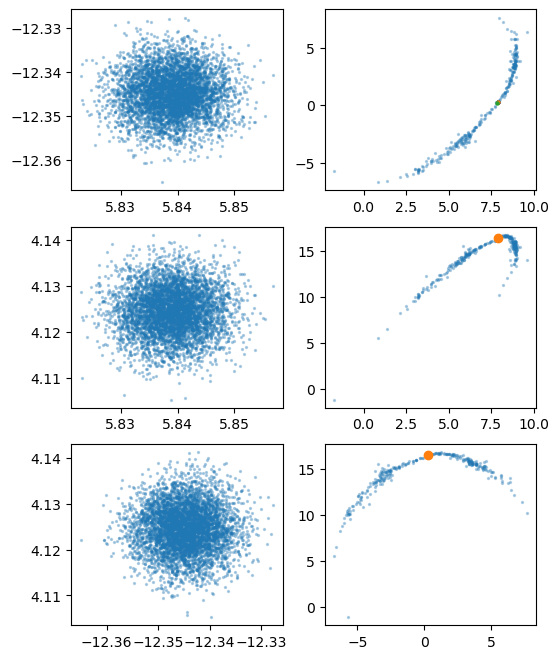

In [8]:
###Plot cluster at the beginning and at the end
#Beginning, initial conidtions
# print(w0.pos.x)
# print(w0.pos.y)
# print(orbits.pos.y[-1])
plt.figure(figsize=(6,8))
#xy
plt.subplot(321)
plt.scatter(w0.pos.x, w0.pos.y, alpha=0.3,s=2)#cluster at t0
plt.subplot(322)
plt.scatter(orbits.pos.x[-1], orbits.pos.y[-1], alpha=0.3,s=2)#sts
plt.scatter(orbits.pos.x[-1][0], orbits.pos.y[-1][0],s=5)#progenitor
plt.scatter(7.86390455, 0.22748727, s=5)

print(c_gc)
print(orbits.pos.x[-1][0], orbits.pos.y[-1][0],orbits.pos.z[-1][0])
#xz
plt.subplot(323)
plt.scatter(w0.pos.x, w0.pos.z, alpha=0.3,s=2)
plt.subplot(324)
plt.scatter(orbits.pos.x[-1], orbits.pos.z[-1], alpha=0.3,s=2)
plt.scatter(orbits.pos.x[-1][0], orbits.pos.z[-1][0])

#yz
plt.subplot(325)
plt.scatter(w0.pos.y, w0.pos.z, alpha=0.3,s=2)
plt.subplot(326)
plt.scatter(orbits.pos.y[-1], orbits.pos.z[-1], alpha=0.3,s=2)
plt.scatter(orbits.pos.y[-1][0], orbits.pos.z[-1][0])


plt.show()

Text(0.5, 0, 'Z')

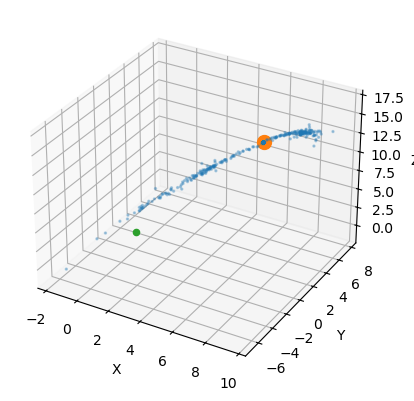

In [9]:
#3D representation

fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(orbits.pos.x[-1], orbits.pos.y[-1], orbits.pos.z[-1], alpha=0.3,s=2)#sts
ax3.scatter(orbits.pos.x[-1][0], orbits.pos.y[-1][0], orbits.pos.z[-1][0], s=100)#progenitor
ax3.scatter(0,0,0)#galatic center

ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')

/tmp/ipykernel_19898/1673074564.py:10: RuntimeWarning: invalid value encountered in divide
  theta = np.arccos(z / r)  # Polar angle
/tmp/ipykernel_19898/1673074564.py:14: RuntimeWarning: invalid value encountered in divide
  vr = (x * vx + y * vy + z * vz) / r  # Radial velocity
/tmp/ipykernel_19898/1673074564.py:15: RuntimeWarning: invalid value encountered in divide
  vtheta = (z * (x * vx + y * vy) - (x**2 + y**2) * vz) / (r * np.sqrt(x**2 + y**2))  # Theta velocity
/tmp/ipykernel_19898/1673074564.py:16: RuntimeWarning: invalid value encountered in divide
  vphi = (x * vy - y * vx) / np.sqrt(x**2 + y**2)  # Phi velocity


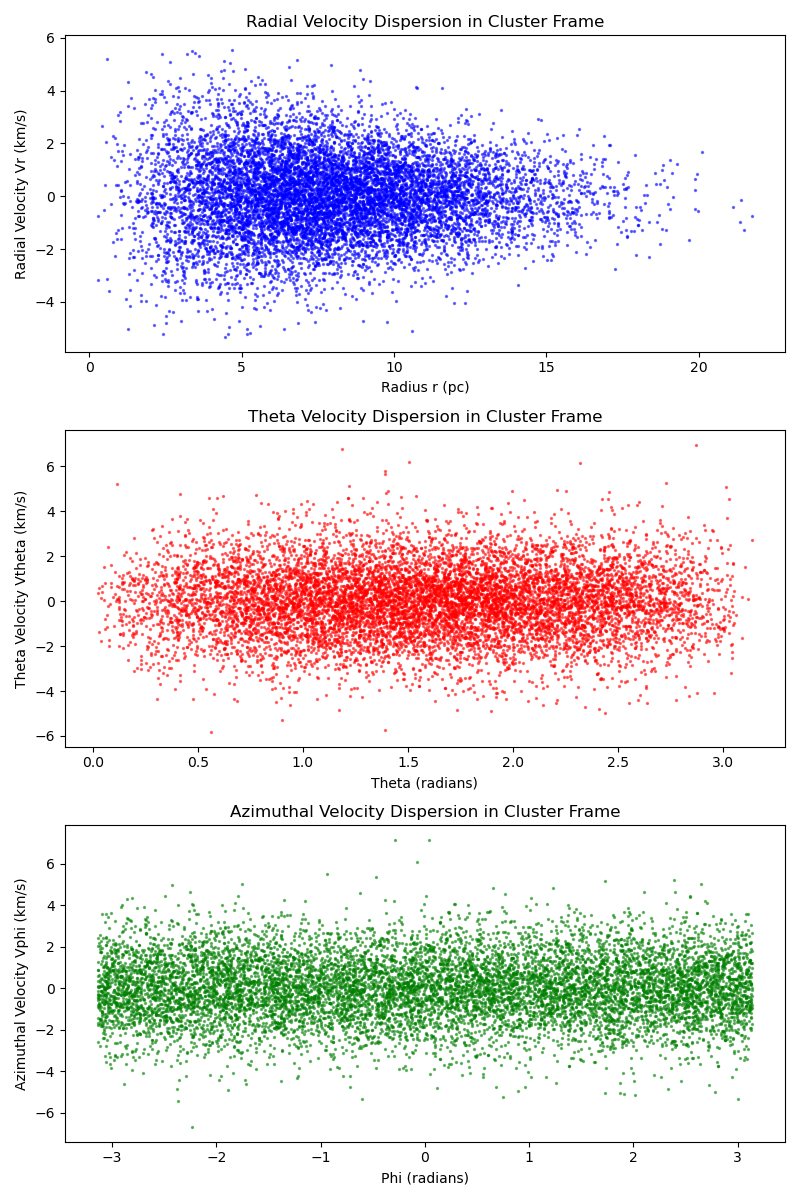

In [10]:

def cartesian_to_spherical_velocity(cluster_pos, cluster_vel, positions, velocities):
    """Convert Cartesian positions and velocities to spherical velocity components in cluster frame."""
    
    # Shift to cluster frame
    x, y, z = positions - cluster_pos[:, None]  # Ensure correct broadcasting
    vx, vy, vz = velocities - cluster_vel[:, None]  # Ensure correct broadcasting
    
    # Compute spherical coordinates relative to the cluster
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)  # Polar angle
    phi = np.arctan2(y, x)  # Azimuthal angle
    
    # Compute velocity components in spherical coordinates
    vr = (x * vx + y * vy + z * vz) / r  # Radial velocity
    vtheta = (z * (x * vx + y * vy) - (x**2 + y**2) * vz) / (r * np.sqrt(x**2 + y**2))  # Theta velocity
    vphi = (x * vy - y * vx) / np.sqrt(x**2 + y**2)  # Phi velocity
    
    return r, theta, phi, vr, vtheta, vphi

# Get cluster's position and velocity
cluster_pos = w0_pal5_b.xyz.to_value(u.pc)  # Shape (3,)
cluster_vel = w0_pal5_b.v_xyz.to_value(u.km/u.s)  # Shape (3,)

# Get stars' positions and velocities
positions = w0.xyz.to_value(u.pc)  # Shape (3, N)
velocities = w0.v_xyz.to_value(u.km/u.s)  # Shape (3, N)

# Transform to spherical coordinates in the cluster's frame
r, theta, phi, vr, vtheta, vphi = cartesian_to_spherical_velocity(cluster_pos, cluster_vel, positions, velocities)

# Create plots
fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# Plot Vr vs R
axes[0].scatter(r, vr, s=2, alpha=0.5, color='b')
axes[0].set_xlabel("Radius r (pc)")
axes[0].set_ylabel("Radial Velocity Vr (km/s)")
axes[0].set_title("Radial Velocity Dispersion in Cluster Frame")

# Plot Vtheta vs Theta
axes[1].scatter(theta, vtheta, s=2, alpha=0.5, color='r')
axes[1].set_xlabel("Theta (radians)")
axes[1].set_ylabel("Theta Velocity Vtheta (km/s)")
axes[1].set_title("Theta Velocity Dispersion in Cluster Frame")

# Plot Vphi vs Phi
axes[2].scatter(phi, vphi, s=2, alpha=0.5, color='g')
axes[2].set_xlabel("Phi (radians)")
axes[2].set_ylabel("Azimuthal Velocity Vphi (km/s)")
axes[2].set_title("Azimuthal Velocity Dispersion in Cluster Frame")

plt.tight_layout()
plt.show()
